In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from IPython.display import display

import psycopg2
from netrc import netrc
from fiona.crs import from_epsg

from shapely.geometry import Point

user, acct, passwd = netrc().authenticators("harris")

seats, fips, epsg = 11, 51, 3687

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000

In [2]:
vaf = "/media/jsaxon/brobdingnag/data/el_dv/va_site/"

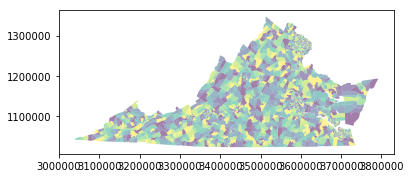

In [23]:
geo_16 = gpd.read_file(vaf + "shp/vaprecincts2016.shp").to_crs(epsg = epsg)
geo_16.rename(columns = {"Number" : "number"}, inplace = True)
geo_16 = geo_16.sort_values(by = ["locality", "number"])[["locality", "precinct", "number", "geometry"]]
geo_16["precinct"] = geo_16["precinct"].str.upper().str.replace("  ", " ").str.replace("  ", " ")
geo_16["locality"] = geo_16["locality"].str.upper()

lunenburg_num = {"PLYMOUTH" : 101, "BROWNS STORE" : 201, "ROSEBUD" : 301, "FLAT ROCK" : 302, 
                 "ARROWHEAD GUN CLUB" : 401, "PLEASANT GROVE" : 402, "REEDY CREEK" : 501, "PEOPLES COMMUNITY CENTER" : 502,
                 "HOUNDS CREEK" : 601, "MEHERRIN FIRE DEPARTMENT" : 701, "VICTORIA PUBLIC LIBRARY" : 702}

for k, v in lunenburg_num.items():
    geo_16.loc[geo_16.locality.str.contains("LUNENBURG") & (geo_16.precinct == k), "number"] = v
    
geo_16.loc[geo_16.locality.str.contains("ROANOKE COUNTY") & geo_16.precinct.str.contains("MASONS"), "precinct"] = "MASON VALLEY"
geo_16.loc[geo_16.locality.str.contains("WASHINGTON COUNTY") & geo_16.precinct.str.contains("ODLAND HILLS"), "precinct"] = "WOODLAND HILLS"

geo_16["number"] = geo_16.number.astype(int)
geo_16.drop_duplicates(subset = ["locality", "precinct", "number"], keep = "first", inplace = True)

geo_16.plot(linewidth = 0)

Roanoke City is its own special case.  I _was_ geocoding [these addresses](http://www.roanokeva.gov/DocumentCenter/Home/View/3180), but instead got the precinct shapefile, [here](ftp://ftp.roanokeva.gov/GIS/Shapefiles/).

In [24]:
# ! curl -F addressFile=@/media/jsaxon/brobdingnag/data/el_dv/va_site/roanoke_city_addr.csv -F benchmark=9 \
#       https://geocoding.geo.census.gov/geocoder/locations/addressbatch | \
#       cut -d, -f1,13,14 | sed "s/\"//g" | sort -k1 -n > /media/jsaxon/brobdingnag/data/el_dv/va_site/roanoke_city_geocoded.csv

# roanoke_coords = pd.read_csv(vaf + "roanoke_city_geocoded.csv", header = None, index_col = "number", names = ["number", "lon", "lat"])
# geometry = [Point(xy) for xy in zip(roanoke_coords.lon, roanoke_coords.lat)]
# roanoke_geo = gpd.GeoDataFrame(roanoke_coords, crs = from_epsg(4269), geometry = geometry).to_crs(epsg = epsg).reset_index()

# roanoke_precincts = pd.read_csv(vaf + "roanoke_city_polls.csv")
# roanoke_precincts.precinct = roanoke_precincts.precinct.str.upper()

# roanoke_geo = roanoke_geo.merge(roanoke_precincts, on = "number")
# roanoke_geo.plot()

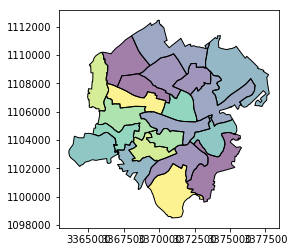

In [25]:
roanoke_city = gpd.read_file(vaf + "roanoke_city_precincts/voting_precincts.shp").to_crs(epsg = epsg)
roanoke_city["precinct"] = roanoke_city.NAME.str.replace("LEE-HI", "LEE HI").str.upper()
roanoke_city["locality"] = "ROANOKE CITY"
roanoke_city["number"] = roanoke_city.VOTER_PREC.astype(int)
roanoke_city.plot()
# roanoke_city

In [26]:
# These are the only other two missing values.
# ESSEX VILLAGE 3901 Pilots Ln, Richmond, VA 23222          -->> -77.4295075, 37.586846
# ROTONDA CONDOMINUMS 8352 Greensboro Dr, McLean, VA 22102  -->> -77.2351243, 38.928249
 
special = gpd.GeoDataFrame(data = {"locality" : ["HENRICO COUNTY", "FAIRFAX COUNTY"], "precinct" : ["ESSEX VILLAGE", "ROTONDA"], "number" : [224, 735]},
                           geometry = [Point([-77.4295075, 37.5868458]), Point([-77.2328882, 38.9282495])],
                           crs = from_epsg(4269)).to_crs(epsg = epsg)

In [27]:
geo_16 = pd.concat([geo_16[geo_16.locality != "ROANOKE CITY"], roanoke_city, special])\
           .sort_values(by = ["locality", "precinct", "number"]).reset_index()\
           [["locality", "precinct", "number", "geometry"]]

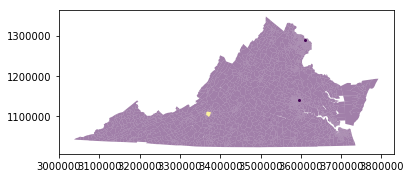

In [8]:
geo_16["is_rc"] = geo_16.locality == "ROANOKE CITY"
geo_16.plot(column = "is_rc", linewidth = 0)

In [28]:
votes_16 = pd.read_csv(vaf + "va_pres_ge_2016.csv", skiprows = [1], 
                       usecols = ['County/City', 'Pct', 'Hillary R. Clinton', 'Donald J. Trump'])
votes_16.rename(columns = {'County/City' : 'locality', 'Pct' : 'precinct', 
                           'Hillary R. Clinton' : "D16", 'Donald J. Trump' : "R16"},
                inplace = True)

votes_16["D16"] = votes_16["D16"].str.replace(",", "").astype(int)
votes_16["R16"] = votes_16["R16"].str.replace(",", "").astype(int)
votes_16 = votes_16[votes_16.locality != "TOTALS"]
vote_check = list(votes_16.sum()[["D16", "R16"]].astype(int))

votes_16['locality'] = votes_16["locality"].str.upper()
votes_16['number'] = votes_16["precinct"].str.replace(r'^([0-9]*)[ -].*', r'\1')
votes_16['precinct'] = votes_16["precinct"].str.upper().str.replace(r'^([0-9]*|AB)([ -]+)([A-Za-z ]*)', r'\3')
votes_16['precinct'] = votes_16["precinct"].str.replace(r' *\(CD[ ]*[0-9]+\)', r'').str.replace("  ", " ")
votes_16['number'] = votes_16["number"].str.replace(r'A[bB].*', "A").str.replace(r'Provisional.*', "P")

# Two Precincts split in Westmoreland County
votes_16.loc[votes_16.locality.str.contains("WEST") & (votes_16.number == "202"), "precinct"] = "PRECINCT 2-1"
votes_16.loc[votes_16.locality.str.contains("WEST") & (votes_16.number == "202"), "number"] = "201"

votes_16.loc[votes_16.locality.str.contains("WEST") & (votes_16.number == "302"), "precinct"] = "PRECINCT 3-1"
votes_16.loc[votes_16.locality.str.contains("WEST") & (votes_16.number == "302"), "number"] = "301"

votes_16 = votes_16.groupby(["locality", "precinct", "number"]).sum().reset_index() # Dupblicates from CDs, Westmoreland, etc.

votes_16 = votes_16[["locality", "precinct", "number", "D16", "R16"]]

In [29]:
vote_check == list(votes_16.sum()[["D16", "R16"]].astype(int))

True

In [30]:
# votes_16[votes_16.locality == "CHESAPEAKE CITY"].sort_values(by = ["locality", "precinct"])

In [31]:
def allocate_prov_abs_votes(votes):

    poll_mask = ~votes.number.str.contains("A") & ~votes.number.str.contains("P")
    
    poll_totals = votes[poll_mask].groupby("locality").sum()[["D16", "R16"]].reset_index()\
                                  .rename(columns = {"D16" : "D16_poll_tot", "R16" : "R16_poll_tot"})\

    alt_totals = votes[~poll_mask].groupby("locality").sum()[["D16", "R16"]].reset_index()\
                                  .rename(columns = {"D16" : "D16_alt_tot", "R16" : "R16_alt_tot"})\
                                          
    votes = pd.merge(votes, poll_totals, on = "locality", how = "outer")
    votes = pd.merge(votes, alt_totals,  on = "locality", how = "outer")
    votes.fillna(0, inplace = True)

    votes["D16_poll_frac"], votes["R16_poll_frac"] = 0, 0
    votes.loc[poll_mask, "D16_poll_frac"] = 1. * votes.loc[poll_mask, "D16"] / votes.loc[poll_mask, "D16_poll_tot"]
    votes.loc[poll_mask, "R16_poll_frac"] = 1. * votes.loc[poll_mask, "R16"] / votes.loc[poll_mask, "R16_poll_tot"]

    votes.loc[poll_mask, "D16"] += votes.loc[poll_mask, "D16_alt_tot"] * votes.loc[poll_mask, "D16_poll_frac"]
    votes.loc[poll_mask, "R16"] += votes.loc[poll_mask, "R16_alt_tot"] * votes.loc[poll_mask, "R16_poll_frac"]
        
    votes = votes.loc[poll_mask, ["locality", "precinct", "number", "D16", "R16"]]
        
    votes["number"] = votes.number.astype(int)
        
    return votes
    
votes_16 = allocate_prov_abs_votes(votes_16)

In [32]:
vote_check == list(votes_16.sum()[["D16", "R16"]].astype(int))

True

In [33]:
# The votes just spell out the number, so no help there.
geo_16.loc[geo_16.locality == "PORTSMOUTH CITY", "precinct"] = ""
votes_16.loc[votes_16.locality == "PORTSMOUTH CITY", "precinct"] = ""

geo_16.loc[geo_16.locality.str.contains("PITTS") & geo_16.precinct.str.contains("EARSKIN"), "precinct"] = "BEARSKIN"
geo_16.loc[geo_16.precinct.str.contains("GRAHAM-GREENWAY"), "precinct"] = "GRAHAM - GREENWAY"
geo_16.loc[geo_16.locality.str.contains("HARRISONBURG CITY") & (geo_16.precinct == "SOUTH EAST"), "precinct"] = "SOUTHEAST"

geo_16.loc[geo_16.locality.str.contains("CHARLOTTE COUNTY") & (geo_16.precinct == "CULLEN"), "precinct"] = "CULLEN/RED HOUSE"
geo_16.loc[geo_16.locality.str.contains("CHARLOTTE COUNTY") & (geo_16.precinct == "SAXE"), "precinct"] = "BACON/SAXE"

# Byrd middle school is on Quioccasin Road.
geo_16.loc[geo_16.locality.str.contains("HENRICO COUNTY") & (geo_16.precinct == "BYRD"), "precinct"] = "QUIOCCASIN"

# Hughes Middle School is adjacent to Terraset Elementary School
geo_16.loc[geo_16.locality.str.contains("FAIRFAX COUNTY") & (geo_16.precinct == "TERRASET"), "precinct"] = "HUGHES"

# Three miles apart
geo_16.loc[geo_16.locality.str.contains("ACCOMACK") & (geo_16.precinct == "OAK HALL"), "precinct"] = "NEW CHURCH"

# Nandua is the local high school for Onancock
geo_16.loc[geo_16.locality.str.contains("ACCOMACK") & (geo_16.precinct == "ONANCOCK"), "precinct"] = "NANDUA"

# Ben Lamond Community Center is 0.8 miles from Ashton Road
geo_16.loc[geo_16.locality.str.contains("WILLIAM") & (geo_16.precinct == "ASHTON"), "precinct"] = "BEN LOMOND"

# Haymarket is the neighborhood, Tyler is the elementary school
geo_16.loc[geo_16.locality.str.contains("WILLIAM") & (geo_16.precinct == "HAYMARKET"), "precinct"] = "TYLER"

# This is the one I'm least sure about -- Godwin Drive is 15 miles from Hampton HS
geo_16.loc[geo_16.locality.str.contains("WILLIAM") & (geo_16.precinct == "GODWIN"), "precinct"] = "HAMPTON"

# Moved from the FD 1.5 miles to the elementary school.
geo_16.loc[geo_16.locality.str.contains("LOUDOUN") & (geo_16.number == 317), "precinct"] = "MADISON'S TRUST"
geo_16.loc[geo_16.locality.str.contains("LOUDOUN") & (geo_16.number == 317), "number"] = 318

# Lee Hi.... remove the dash
geo_16.loc[geo_16.locality.str.contains("ROANOKE CITY") & (geo_16.precinct == "LEE HI"), "precinct"] = "LEE-HI"

va_votes = pd.merge(geo_16, votes_16, on = ["locality", "precinct", "number"], how = "outer")
va_votes = va_votes.sort_values(by = ["locality", "number", "precinct"])

In [34]:
if vote_check == list(va_votes[["D16", "R16"]].sum().round().astype(int)): print("Nice work, stud.")
else: print("Trouble in paradise!!", vote_check, list(va_votes[["D16", "R16"]].sum().round().astype(int)))

Nice work, stud.


In [35]:
va_votes[va_votes.duplicated(subset = {"locality", "number"}, keep = False)].sort_values(by = ["locality", "number"])

,locality,precinct,number,geometry,D16,R16


No lost votes.

In [36]:
va_votes[va_votes.geometry.isnull() | va_votes.D16.isnull()].sort_values(by = ["locality", "number"])

,locality,precinct,number,geometry,D16,R16
10,ACCOMACK COUNTY,ONLEY,702,"POLYGON ((3746684.857552344 1155806.541501651,...",NaN,NaN
342,CHARLOTTE COUNTY,RED HOUSE,503,"POLYGON ((3483787.85239797 1100330.95843827, 3...",NaN,NaN
336,CHARLOTTE COUNTY,BACON,701,"POLYGON ((3480891.43423604 1078997.82137199, 3...",NaN,NaN
651,FAIRFAX COUNTY,FAIRFAX COURT,700,"POLYGON ((3603280.663520052 1279631.213854346,...",NaN,NaN


In [37]:
va_votes['geometry'] = va_votes.centroid
va_votes.to_file(vaf + "va_votes.shp")

In [38]:
query = """SELECT rn, ST_Transform(tr.geom, epsg) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
              tr.state  = rn.state AND tr.county = rn.county AND tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = {};"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_map = gpd.GeoDataFrame.from_postgis(query.format(fips), con, geom_col = "geometry", crs = from_epsg(epsg))

In [39]:
def merge_tract_number(gdf, trdf):

    gdf["rn"] = float('nan')

    for pri, row in gdf.iterrows():
        ctr = row.geometry.centroid
        distances = [(xi, pt.distance(ctr)) for xi, pt in enumerate(trdf.geometry)]
        match = min(distances, key=lambda item:item[1])[0]
        gdf.loc[pri, "rn"] = match
        if (pri % 100) == 0: print(pri, end = " ")
            
    print()

merge_tract_number(va_votes, tr_map)
va_votes.rn = va_votes.rn.astype(int)
va_votes = va_votes.groupby("rn").sum()[["D16", "R16"]].sort_index()

0 100 200 300 400 500 700 800 600 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 


In [40]:
va_votes.to_csv("va_votes.csv")
pd.read_csv("va_votes.csv", index_col = "rn").head()

,D16,R16
rn,,
0,1340.598837,927.759259
2,1515.538408,867.399700
3,813.653984,2022.093832
5,2118.045291,501.320388
6,641.274839,3680.190527
